In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import ttest_ind, pearsonr
from tqdm import tqdm
from rapidfuzz import fuzz
from operator import itemgetter
from matplotlib import colors

from helpers import *

import warnings

# Ignoring warnings to improve code readability
warnings.filterwarnings("ignore")

# Resetting Matplotlib default settings
plt.rcdefaults()

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 20)

%load_ext autoreload
%autoreload 2

In [2]:
DATA_FOLDER = "../Data/"

actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_dict_to_list,
        "countries": parse_dict_to_list,
        "genres": parse_list,
    },
)

In [3]:
actors = actors_load.copy()
movies = movies_load.copy()

In [4]:
print(actors.shape)
actors.head(100)

(135422, 12)


,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,1964.0,"[/m/03qk61v, /m/047dv64, /m/051wrdv, /m/06c5z_...","{'/m/03qk61v': 44.0, '/m/051wrdv': 35.0, '/m/0...",NaN,NaN,11
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1
2,/m/010wx,Aria Giovanni,F,1977-11-03,1.680,NaN,1977.0,[/m/07gx0c],{'/m/07gx0c': 25.0},NaN,NaN,1
3,/m/010xjr,Richard Harris,M,1930-10-01,1.850,Irish people,1930.0,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.740,NaN,1920.0,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48
...,...,...,...,...,...,...,...,...,...,...,...,...
95,/m/012qgc,Max Schmeling,M,1905-09-28,1.850,Germans,1905.0,"[/m/0bb_0pq, /m/0bf6xp]","{'/m/0bb_0pq': 47.0, '/m/0bf6xp': 64.0}",NaN,NaN,2
96,/m/012rpb,George Dewey,M,1837-12-26,NaN,NaN,1837.0,[/m/0bbr0sm],NaN,NaN,NaN,1
97,/m/012s5j,Raquel Welch,F,1940-09-05,1.680,Bolivian American,1940.0,"[/m/0296vv, /m/02q6hzv, /m/02r1ynz, /m/02r4d_,...","{'/m/0296vv': 60.0, '/m/02q6hzv': 27.0, '/m/02...",NaN,NaN,34
98,/m/012sq7,Richard Simmons,M,1948-07-12,NaN,NaN,1948.0,[/m/051xtx9],{'/m/051xtx9': 50.0},NaN,NaN,1


In [5]:
actors.category[actors.category.notna()].apply(
    lambda d: list(d.values()) if isinstance(d, dict) else []).explode().unique()

array(['ACTOR', 'ACTRESS IN A SUPPORTING ROLE',
       'ACTOR IN A SUPPORTING ROLE', 'ACTOR IN A LEADING ROLE', 'ACTRESS',
       'ACTRESS IN A LEADING ROLE'], dtype=object)

out of 135422 actors, there are 807 unique oscar nominees


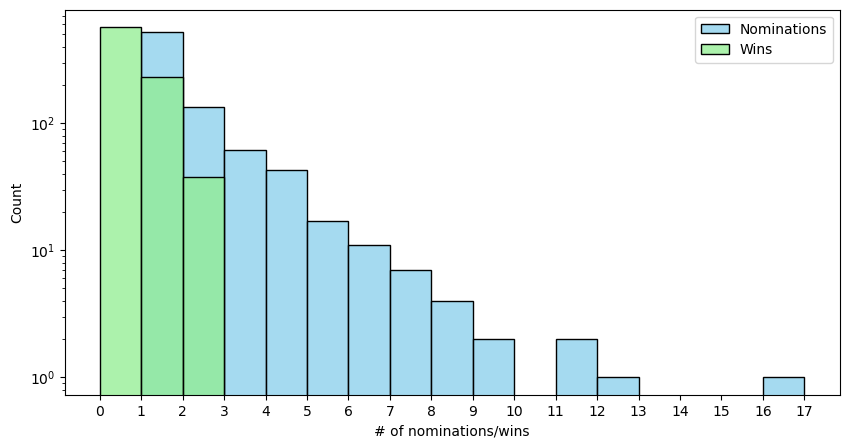

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies,nominations,wins,won,wonAgain
0,/m/010p3,Adam Carolla,M,1964-05-27,1.88,NaN,1964.0,"[/m/03qk61v, /m/047dv64, /m/051wrdv, /m/06c5z_...","{'/m/03qk61v': 44.0, '/m/051wrdv': 35.0, '/m/0...",NaN,NaN,11,NaN,NaN,False,False
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1,NaN,NaN,False,False
2,/m/010wx,Aria Giovanni,F,1977-11-03,1.68,NaN,1977.0,[/m/07gx0c],{'/m/07gx0c': 25.0},NaN,NaN,1,NaN,NaN,False,False
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52,1.0,0.0,False,False
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.74,NaN,1920.0,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48,NaN,NaN,False,False


In [6]:
# compute actor nominations
actors['nominations'] = actors['category'].dropna().apply(lambda x: len(x))

actors['wins'] = actors['winner'].dropna().apply(lambda x: sum(x.values()))

actors['won'] = actors['wins'] > 0.0

actors['wonAgain'] = actors['wins'] > 1.0

print(f"out of {actors.shape[0]} actors, there are {sum(actors['nominations'] > 0.0)} unique oscar nominees")

plt.figure(figsize=(10, 5))
sns.histplot(actors['nominations'], binwidth=1, log_scale=(False, True), color='skyblue', label='Nominations')
sns.histplot(actors['wins'], binwidth=1, log_scale=(False, True), color='lightgreen', label='Wins')
plt.xlabel('# of nominations/wins')
plt.xticks(np.arange(0, 18, 1))
plt.legend()
plt.show()
actors.head()

<Axes: >

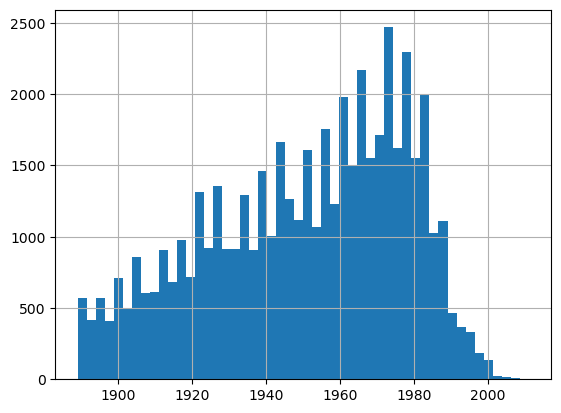

In [7]:
actors[actors.yearOfBirth > 1888].yearOfBirth.hist(bins=50)

In [8]:
# Define a function to extract the minimum age from the ageAtMovieRelease dictionary
def get_min_age(x):
    if isinstance(x, dict):
        return min(x.values())
    else:
        return np.nan


def get_max_age(x):
    if isinstance(x, dict):
        return max(x.values())
    else:
        return np.nan


actors_after_1888 = actors[actors['yearOfBirth'] > 1888.0]
# Apply the function to the ageAtMovieRelease column
actors_after_1888['ageAtFirstMovie'] = actors_after_1888['ageAtMovieRelease'].apply(get_min_age)

actors_full_career = actors_after_1888[actors_after_1888['yearOfBirth'] < movies['releaseYear'].max() - 61]
# Apply the function to the ageAtMovieRelease column
actors_full_career['ageAtLastMovie'] = actors_full_career['ageAtMovieRelease'].apply(get_max_age)
# Calculate career length
actors_full_career['careerLength'] = actors_full_career['ageAtLastMovie'] - actors_full_career['ageAtFirstMovie']

display(actors_full_career)
print(
    f"Keeping only actors with a full career, we have {actors_full_career.shape[0]} actors, of which there are {sum(actors_full_career['nominations'] > 0.0)} unique oscar nominees")

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies,nominations,wins,won,wonAgain,ageAtFirstMovie,ageAtLastMovie,careerLength
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1,NaN,NaN,False,False,67.0,67.0,0.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52,1.0,0.0,False,False,28.0,72.0,44.0
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.74,NaN,1920.0,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48,NaN,NaN,False,False,28.0,69.0,41.0
6,/m/011_24,Les Brown,M,1912-03-14,NaN,NaN,1912.0,"[/m/02stxk, /m/09n9rnb]","{'/m/02stxk': 50.0, '/m/09n9rnb': 30.0}",NaN,NaN,2,NaN,NaN,False,False,30.0,50.0,20.0
8,/m/011_3s,Lily Tomlin,F,1939-09-01,1.73,NaN,1939.0,"[/m/027qjyd, /m/028kj0, /m/02phv19, /m/02q3fdr...","{'/m/027qjyd': 52.0, '/m/028kj0': 62.0, '/m/02...",{'/m/0j_t1': 'ACTRESS IN A SUPPORTING ROLE'},{'/m/0j_t1': False},27,1.0,0.0,False,False,37.0,69.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135413,/m/0ywqc,Donald Sutherland,M,1935-07-17,1.93,NaN,1935.0,"[/m/01_jty, /m/01cbx, /m/01gm5j, /m/01sy99, /m...","{'/m/01_jty': 59.0, '/m/01cbx': 57.0, '/m/01gm...",NaN,NaN,111,NaN,NaN,False,False,29.0,76.0,47.0
135414,/m/0yxl,Alan Moore,M,1953-11-18,NaN,NaN,1953.0,[/m/0c7qn5],{'/m/0c7qn5': 49.0},NaN,NaN,1,NaN,NaN,False,False,49.0,49.0,0.0
135415,/m/0z05l,Graham Greene,M,1952-06-22,1.79,First Nations,1952.0,"[/m/01_1hw, /m/021jdm, /m/02748ds, /m/02rtv28,...","{'/m/01_1hw': 42.0, '/m/021jdm': 41.0, '/m/027...",{'/m/0y_9q': 'ACTOR IN A SUPPORTING ROLE'},{'/m/0y_9q': False},27,1.0,0.0,False,False,31.0,58.0,27.0
135416,/m/0z4s,Anthony Hopkins,M,1937-12-31,1.74,Irish people in Great Britain,1937.0,"[/m/012y5v, /m/016z5x, /m/016z9n, /m/018tmf, /...","{'/m/012y5v': 46.0, '/m/016z5x': 54.0, '/m/016...","{'/m/016z9n': 'ACTOR IN A LEADING ROLE', '/m/0...","{'/m/016z9n': False, '/m/0260bz': False, '/m/0...",80,4.0,1.0,True,False,29.0,76.0,47.0


Keeping only actors with a full career, we have 25344 actors, of which there are 586 unique oscar nominees


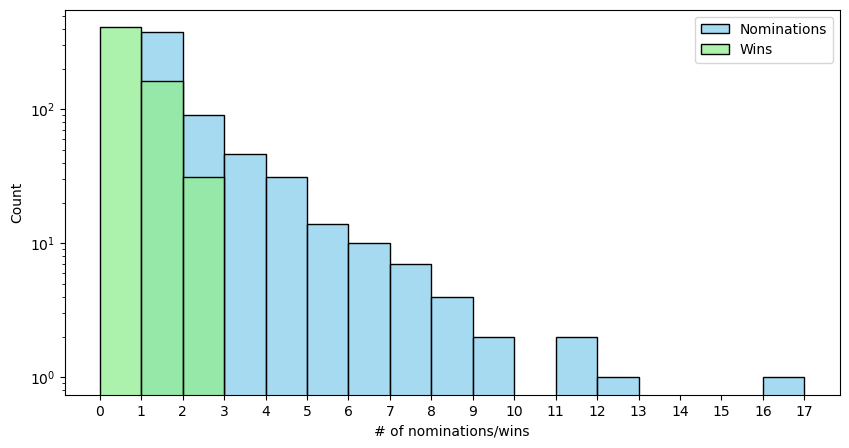

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(actors_full_career['nominations'], binwidth=1, log_scale=(False, True), color='skyblue',
             label='Nominations')
sns.histplot(actors_full_career['wins'], binwidth=1, log_scale=(False, True), color='lightgreen', label='Wins')
plt.xlabel('# of nominations/wins')
plt.xticks(np.arange(0, 18, 1))
plt.legend()
plt.show()
# exponential decay

In [10]:
print(
    f"there are {sum(actors_full_career.dropna(subset='actorEthnicity')['nominations'] > 0.0)} unique oscar nominees with ethnicity information")
print(
    f"there are {sum(actors_full_career.dropna(subset=('careerLength'))['nominations'] > 0.0)} unique oscar nominees with career length information")
print(
    f"there are {sum(actors_full_career.dropna(subset=('actorHeight'))['nominations'] > 0.0)} unique oscar nominees with height information")
print(
    f"there are {sum(actors_full_career.dropna(subset=('careerLength', 'actorHeight'))['nominations'] > 0.0)} unique oscar nominees with height and career length information")

there are 133 unique oscar nominees with ethnicity information
there are 528 unique oscar nominees with career length information
there are 440 unique oscar nominees with height information
there are 415 unique oscar nominees with height and career length information


considering 415 actors
Logistic Regression results over 10 folds
Accuracy: 0.720 ± 0.099
F1 Score: 0.657 ± 0.121


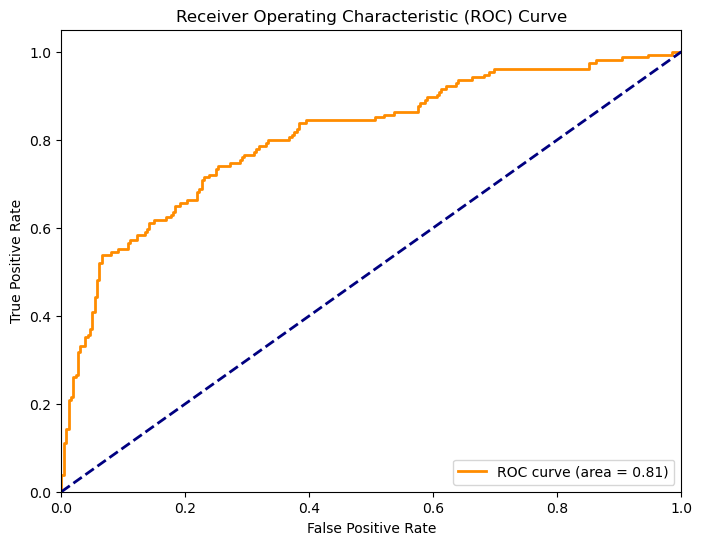

Best Threshold: 0.308, G-Mean: 0.744

On whole dataset:
Accuracy: 0.742
F1 score: 0.679

Baseline - random Guess F1 Score: 0.369


,actorGender,actorHeight,numMovies,ageAtFirstMovie,careerLength,nominations,won,propensityScore_sk
3,M,1.850,52,28.0,44.0,1.0,False,0.237514
8,F,1.730,27,37.0,32.0,1.0,False,0.243919
38,M,1.770,21,25.0,45.0,1.0,False,0.207113
61,M,1.750,28,25.0,25.0,1.0,False,0.105597
65,F,1.626,38,17.0,59.0,1.0,False,0.305219
...,...,...,...,...,...,...,...,...
135322,M,1.750,11,25.0,8.0,1.0,False,0.058155
135331,M,1.840,43,26.0,31.0,6.0,True,0.876220
135392,M,1.778,37,35.0,40.0,3.0,True,0.557817
135415,M,1.790,27,31.0,27.0,1.0,False,0.138237


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc

actors_oscars = actors_full_career[
    ['actorGender', 'actorHeight', 'numMovies', 'ageAtFirstMovie', 'careerLength', 'nominations', 'won']].dropna()
print(f"considering {actors_oscars.shape[0]} actors\n")

# Selecting columns for the analysis
X = actors_oscars[['actorGender', 'actorHeight', 'numMovies', 'ageAtFirstMovie', 'nominations', 'careerLength']]
y = actors_oscars['won']

# Preprocessing: Encoding categorical variables and scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['actorHeight', 'numMovies', 'ageAtFirstMovie', 'nominations', 'careerLength']),
        ('cat', OneHotEncoder(), ['actorGender'])
    ])

# Logistic Regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

# Define the K-Fold cross-validation
k_folds = 10
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=17)


def custom_evaluation(model, X_test, y_test, threshold=0.5):
    # Predict probabilities
    probs = model.predict_proba(X_test)[:, 1]
    # Apply threshold to determine class predictions
    preds = (probs >= threshold).astype(int)
    # Calculate desired metrics
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    return acc, f1


# Initialize lists to store metrics for each fold
acc_scores = []
f1_scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    acc, f1 = custom_evaluation(model, X_test, y_test, threshold=0.3)
    acc_scores.append(acc)
    f1_scores.append(f1)

print(f"Logistic Regression results over {k_folds} folds")
print(f"Accuracy: {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")
print(f"F1 Score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

# Fit the model to the entire dataset
model.fit(X, y)

# Compute predicted probabilities
predicted_probabilities = model.predict_proba(X)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate the G-mean for each threshold
gmeans = np.sqrt(tpr * (1 - fpr))
# Locate the index of the largest G-mean, i.e. best threshold in the Youden's J statistic sense
ix = np.argmax(gmeans)
print(f'Best Threshold: {thresholds[ix]:.3f}, G-Mean: {gmeans[ix]:.3f}')

print(f"\nOn whole dataset:\nAccuracy: {accuracy_score(y, predicted_probabilities > thresholds[ix]):.3f}")
print(f"F1 score: {f1_score(y, predicted_probabilities > thresholds[ix]):.3f}")

# Generate random predictions that match the class distribution
unique, counts = np.unique(y, return_counts=True)
class_distribution = counts / counts.sum()
random_predictions = np.random.choice(unique, size=len(y), p=class_distribution)
# Calculate the F1 score for these random predictions
random_f1 = f1_score(y, random_predictions)
print(f"\nBaseline - random Guess F1 Score: {random_f1:.3f}")

# If you need to attach these scores back to your original DataFrame
actors_oscars['propensityScore_sk'] = predicted_probabilities
actors_oscars

In [12]:
import statsmodels.formula.api as smf

standardize = lambda x: (x - x.mean()) / x.std()

actors_full_career.nominations.fillna(0.0, inplace=True)
actors_oscars = actors_full_career[
    ['actorGender', 'actorHeight', 'numMovies', 'ageAtFirstMovie', 'careerLength', 'nominations', 'won']].dropna()
print(f"considering {actors_oscars.shape[0]} actors\n")

# statsmodels has trouble with boolean values..
actors_oscars['won'] = actors_oscars['won'].astype(int)

# standardize the continuous features
actors_oscars['actorHeight'] = standardize(actors_oscars['actorHeight'])
actors_oscars['numMovies'] = standardize(actors_oscars['numMovies'])
actors_oscars['ageAtFirstMovie'] = standardize(actors_oscars['ageAtFirstMovie'])
actors_oscars['nominations'] = standardize(actors_oscars['nominations'])
actors_oscars['careerLength'] = standardize(actors_oscars['careerLength'])

model = smf.logit(
    formula='won ~ C(actorGender) + actorHeight + numMovies + ageAtFirstMovie + careerLength + nominations',
    data=actors_oscars)

res = model.fit()

# extract the estimated propensity scores
actors_oscars['propensityScore_sm'] = res.predict()

print(res.summary())

# Exponentiating the coefficients to get odds ratios
odds_ratios = np.exp(res.params)
print(f"Odd ratios:\n{odds_ratios})")

actors_oscars

considering 3451 actors
Optimization terminated successfully.
         Current function value: 0.081320
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    won   No. Observations:                 3451
Model:                          Logit   Df Residuals:                     3444
Method:                           MLE   Df Model:                            6
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.5584
Time:                        17:21:55   Log-Likelihood:                -280.63
converged:                       True   LL-Null:                       -635.48
Covariance Type:            nonrobust   LLR p-value:                4.925e-150
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.2104      0.286    -14.706      0.000   

,actorGender,actorHeight,numMovies,ageAtFirstMovie,careerLength,nominations,won,propensityScore_sm
3,M,0.851955,1.442772,-0.238940,1.051332,0.783101,0,0.084713
4,M,-0.089194,1.266762,-0.238940,0.879471,-0.263156,0,0.014428
8,F,-0.174753,0.342711,0.502221,0.363890,0.783101,0,0.073978
19,M,0.424160,-0.449332,0.255167,0.936758,-0.263156,0,0.014977
20,M,0.253042,-0.273322,-0.238940,-0.724559,-0.263156,0,0.002479
...,...,...,...,...,...,...,...,...
135406,F,-0.850669,-0.713347,1.737489,-1.125567,-0.263156,0,0.004654
135411,M,0.851955,-0.757349,0.008113,0.994045,-0.263156,0,0.014852
135413,M,1.536426,4.038914,-0.156589,1.223192,-0.263156,0,0.038984
135415,M,0.338601,0.342711,0.008113,0.077456,0.783101,0,0.029179


In [13]:
from scipy import stats

correlation, p_value = stats.pointbiserialr(actors_oscars['actorGender'].map({'M': 1, 'F': 0}),
                                            actors_oscars['nominations'])
print(f"Point-Biserial Correlation: {correlation}, P-value: {p_value}")
# statistically significant negative correlation between actor gender being male and number of nominations

Point-Biserial Correlation: -0.06700947286465708, P-value: 8.165572223398323e-05


In [14]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1 - np.abs(propensity_score1 - propensity_score2)

In [15]:

actors_oscars.shape


(3451, 8)

In [16]:
explode_on_movies(actors_full_career)

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies,nominations,wins,won,wonAgain,ageAtFirstMovie,ageAtLastMovie,careerLength
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,/m/033pf1,67.0,NaN,NaN,1,0.0,NaN,False,False,67.0,67.0,0.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/015gl2,NaN,ACTOR,False,52,1.0,0.0,False,False,28.0,72.0,44.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/0273r02,68.0,None,None,52,1.0,0.0,False,False,28.0,72.0,44.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/02qf1bq,36.0,None,None,52,1.0,0.0,False,False,28.0,72.0,44.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/02qf7sl,64.0,None,None,52,1.0,0.0,False,False,28.0,72.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135416,/m/0z4s,Anthony Hopkins,M,1937-12-31,1.74,Irish people in Great Britain,1937.0,/m/0kv238,72.0,None,None,80,4.0,1.0,True,False,29.0,76.0,47.0
135416,/m/0z4s,Anthony Hopkins,M,1937-12-31,1.74,Irish people in Great Britain,1937.0,/m/0kv36n,69.0,None,None,80,4.0,1.0,True,False,29.0,76.0,47.0
135416,/m/0z4s,Anthony Hopkins,M,1937-12-31,1.74,Irish people in Great Britain,1937.0,/m/0m9p3,39.0,None,None,80,4.0,1.0,True,False,29.0,76.0,47.0
135416,/m/0z4s,Anthony Hopkins,M,1937-12-31,1.74,Irish people in Great Britain,1937.0,/m/0qmd5,42.0,None,None,80,4.0,1.0,True,False,29.0,76.0,47.0


In [17]:
actors_full_career.head()

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies,nominations,wins,won,wonAgain,ageAtFirstMovie,ageAtLastMovie,careerLength
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1,0.0,NaN,False,False,67.0,67.0,0.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52,1.0,0.0,False,False,28.0,72.0,44.0
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.74,NaN,1920.0,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48,0.0,NaN,False,False,28.0,69.0,41.0
6,/m/011_24,Les Brown,M,1912-03-14,NaN,NaN,1912.0,"[/m/02stxk, /m/09n9rnb]","{'/m/02stxk': 50.0, '/m/09n9rnb': 30.0}",NaN,NaN,2,0.0,NaN,False,False,30.0,50.0,20.0
8,/m/011_3s,Lily Tomlin,F,1939-09-01,1.73,NaN,1939.0,"[/m/027qjyd, /m/028kj0, /m/02phv19, /m/02q3fdr...","{'/m/027qjyd': 52.0, '/m/028kj0': 62.0, '/m/02...",{'/m/0j_t1': 'ACTRESS IN A SUPPORTING ROLE'},{'/m/0j_t1': False},27,1.0,0.0,False,False,37.0,69.0,32.0


In [18]:
# standardize the continuous features
actors_full_career['actorHeight'] = standardize(actors_full_career['actorHeight'])
actors_full_career['numMovies'] = standardize(actors_full_career['numMovies'])
actors_full_career['ageAtFirstMovie'] = standardize(actors_full_career['ageAtFirstMovie'])
actors_full_career['ageAtLastMovie'] = standardize(actors_full_career['ageAtLastMovie'])
actors_full_career['nominations'] = standardize(actors_full_career['nominations'])
actors_full_career['careerLength'] = standardize(actors_full_career['careerLength'])

actors_full_career['nominated'] = actors_full_career['nominations'] > 0.0
# statsmodels has trouble with boolean values..
actors_full_career['nominated'] = actors_full_career['nominated'].astype(int)

model = smf.logit(
    formula='nominated ~ C(actorGender) + numMovies + ageAtFirstMovie + careerLength', data=actors_full_career)
# actorHeight +
res = model.fit()

print(res.summary())
# Exponentiating the coefficients to get odds ratios
odds_ratios = np.exp(res.params)
print(f"Odd ratios:\n{odds_ratios})")

model = smf.ols(
    formula='nominations ~ C(actorGender) + actorHeight + numMovies + ageAtFirstMovie + careerLength',
    data=actors_full_career)
# actorHeight +
res = model.fit()

print(res.summary())


Optimization terminated successfully.
         Current function value: 0.078174
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              nominated   No. Observations:                22027
Model:                          Logit   Df Residuals:                    22022
Method:                           MLE   Df Model:                            4
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.3089
Time:                        17:21:57   Log-Likelihood:                -1721.9
converged:                       True   LL-Null:                       -2491.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.1367      0.094    -44.231      0.000      -4.320      -3.953
C(

In [19]:
actors_nominations = actors_full_career.dropna(subset=('nominations', 'winner', 'ageAtMovieRelease', 'actorGender'))
print(f"unique nominations: {actors_nominations.shape[0]}"
      f"\ntotal nominations: {sum(actors_nominations['nominations']):.0f}")

unique nominations: 545
total nominations: 2554


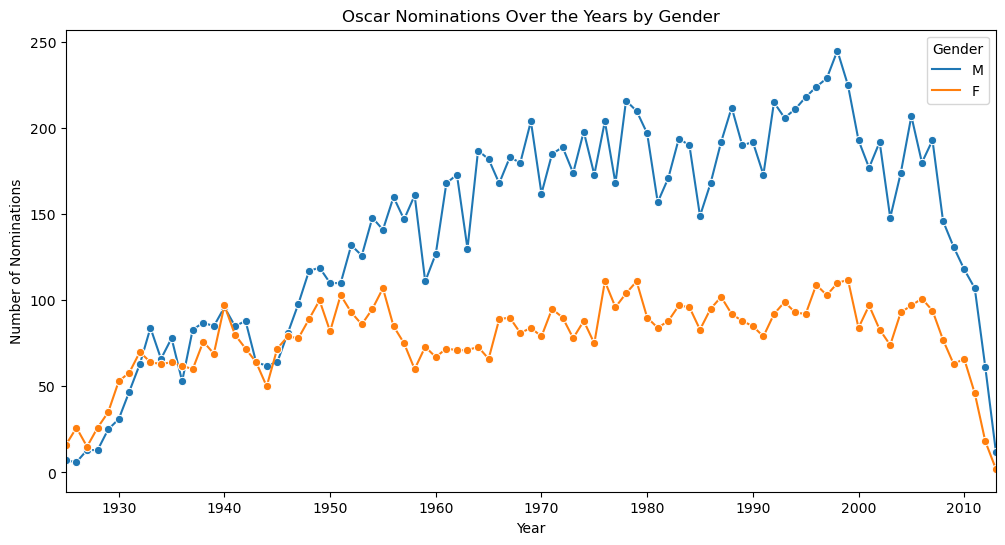

,Year,totalNominations,Gender,totalNominationsPerGender,proportionNominations
0,1917.0,1,M,1,1.000000
1,1918.0,1,F,1,1.000000
2,1921.0,1,F,1,1.000000
3,1922.0,3,F,3,1.000000
4,1923.0,7,F,7,1.000000
...,...,...,...,...,...
181,2012.0,79,F,18,0.227848
182,2012.0,79,M,61,0.772152
183,2013.0,14,F,2,0.142857
184,2013.0,14,M,12,0.857143


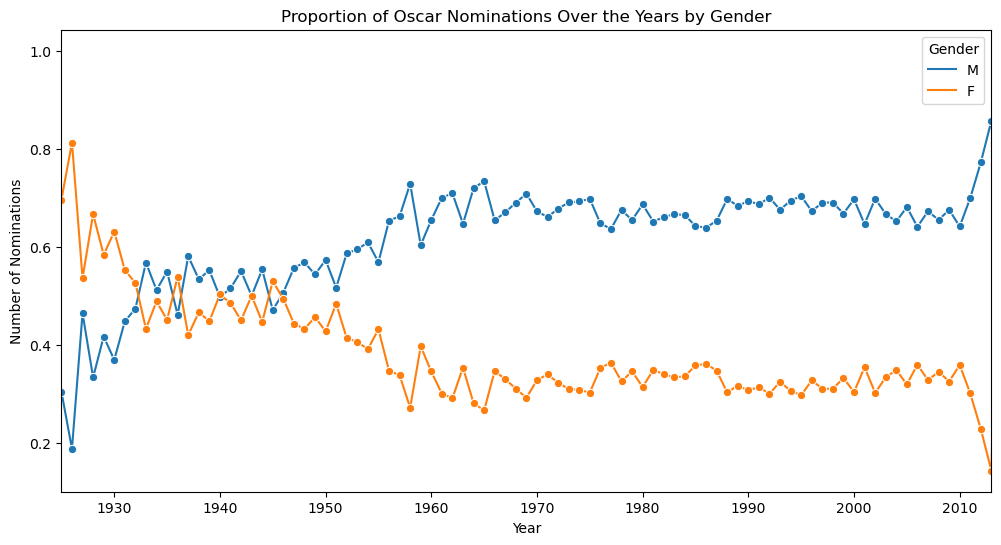

In [20]:
# Function to calculate the year of movie release
def calculate_year_of_release(birth_year, age_at_release):
    return birth_year + age_at_release


# Expand the dictionaries into a DataFrame
rows = []
for i, row in actors_nominations.iterrows():
    for movie_id, age in row['ageAtMovieRelease'].items():
        year_of_release = calculate_year_of_release(row['yearOfBirth'], age)
        won_oscar = row['winner'].get(movie_id, False)
        rows.append({'Year': year_of_release, 'WonOscar': won_oscar, 'Gender': row['actorGender']})

expanded_df = pd.DataFrame(rows)

# Count the number of nominations per year by gender
nomination_counts = expanded_df.groupby(['Year', 'Gender']).size().reset_index(name='Nominations')

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=nomination_counts, x='Year', y='Nominations', hue='Gender', marker='o')

plt.title('Oscar Nominations Over the Years by Gender')
plt.xlabel('Year')
plt.ylabel('Number of Nominations')
plt.xlim(1925, 2013)
plt.show()

nominations_per_year_gender = expanded_df.groupby(['Year', 'Gender']).size().reset_index(
    name='totalNominationsPerGender')
nominations_per_year = expanded_df.groupby('Year').size().reset_index(name='totalNominations')

merged_df = pd.merge(nominations_per_year, nominations_per_year_gender, on='Year')
merged_df['proportionNominations'] = merged_df['totalNominationsPerGender'] / merged_df['totalNominations']
display(merged_df)

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='Year', y='proportionNominations', hue='Gender', marker='o')

plt.title('Proportion of Oscar Nominations Over the Years by Gender')
plt.xlabel('Year')
plt.ylabel('Number of Nominations')
plt.xlim(1925, 2013)
plt.show()

In [21]:
expanded_df[expanded_df['WonOscar'] == True]

,Year,WonOscar,Gender
283,1952.0,True,M
342,1997.0,True,M
573,1969.0,True,M
724,1979.0,True,F
813,1958.0,True,M
...,...,...,...
19295,1964.0,True,M
19364,2000.0,True,M
19370,1988.0,True,M
19430,1949.0,True,M


In [22]:
from scipy.stats import ttest_ind

ttest_ind(nomination_counts[nomination_counts['Gender'] == 'M']['Nominations'],
          nomination_counts[nomination_counts['Gender'] == 'F']['Nominations'])

TtestResult(statistic=8.86910208911022, pvalue=6.372457344626569e-16, df=184.0)

<Figure size 1200x600 with 0 Axes>

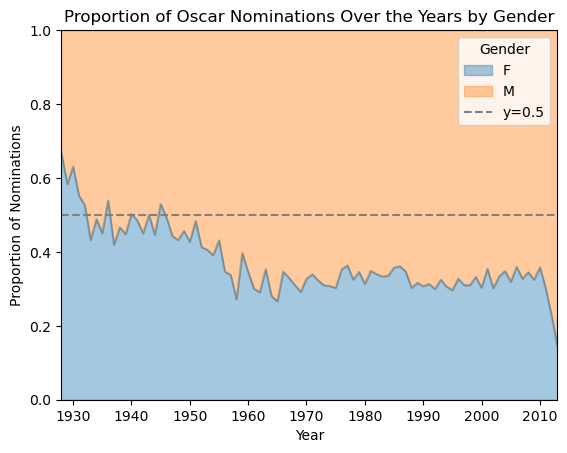

In [27]:
# pivot dataframe to get years as the index and genders as columns
pivot_df = merged_df.pivot(index='Year', columns='Gender', values='proportionNominations')

plt.figure(figsize=(12, 6))
pivot_df.plot(kind='area', stacked=True, alpha=0.4)

plt.title('Proportion of Oscar Nominations Over the Years by Gender')
plt.xlabel('Year')
plt.ylabel('Proportion of Nominations')
plt.xlim(1928, 2013)
plt.ylim(0, 1)
plt.axhline(y=0.5, linestyle='--', color='grey', label='y=0.5')
plt.legend(title='Gender')
plt.show()
